# Simple Example of a Simulation in jf1uids

## Imports

In [1]:
import jax.numpy as jnp

from jf1uids import SimulationConfig
from jf1uids import SimulationParams
from jf1uids import get_helper_data
from jf1uids.fluid_equations.fluid import construct_primitive_state1D
from jf1uids import time_integration

from jf1uids.option_classes.simulation_config import OSHER, MINMOD
from jf1uids.option_classes.simulation_config import SPHERICAL

from jf1uids import get_registered_variables

import matplotlib.pyplot as plt

## Simulation Setup

Let us set up a very simple simulation, mostly with default parameters.

First we get the configuration of the simulation, which contains parameters that typically do not change between simulations, changing which requires (just-in-time)-recompilation.

In [2]:
from jf1uids.option_classes.simulation_config import CARTESIAN, HLL, HLLC, PERIODIC_BOUNDARY, BoundarySettings1D

config = SimulationConfig(
    geometry = CARTESIAN,
    limiter = MINMOD,
    num_cells = 1001,
    boundary_settings = BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY),
    riemann_solver = HLL,
    first_order_fallback = False
)

Next we setup the simulation parameters, things we might vary

In [3]:
params = SimulationParams(
    t_end = 0.4 # the typical value for a shock test
)

With this we generate some helper data, like the cell centers etc.

In [4]:
helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

2025-02-10 15:35:40.838898: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


Next we setup the shock initial conditions, namely
\begin{equation}
\left(\begin{array}{l}
\rho \\
u \\
p
\end{array}\right)_L=\left(\begin{array}{l}
1 \\
0 \\
1
\end{array}\right), \quad\left(\begin{array}{l}
\rho \\
u \\
p
\end{array}\right)_R=\left(\begin{array}{c}
0.125 \\
0 \\
0.1
\end{array}\right)
\end{equation}
with seperation at $x=0.5$.

In [5]:
r = helper_data.geometric_centers
# Advecting Gaussian parameters
pulse_center = 0.5  # Start slightly off-center to test wrapping
pulse_width = 0.1
advection_speed = 5.0  # Should wrap completely every 1.0 time units

# Initial density (Gaussian pulse)
rho = jnp.exp(-((r - pulse_center)**2) / (2*pulse_width**2))

# Constant velocity field (entire domain moves at same speed)
u = jnp.ones_like(r) * advection_speed

# Uniform pressure (avoids pressure gradient effects)
p = jnp.ones_like(r)
# get initial state
initial_state = construct_primitive_state1D(rho, u, p, registered_variables)

## Running the simulation

In [8]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)
rho_final, u_final, p_final = final_state

print(final_state)

[[0.01077208 0.01109963 0.01143606 ... 0.01109963 0.01143606 0.01178155]
 [5.000505   5.0004992  5.0004888  ... 5.0004992  5.0004888  5.0004816 ]
 [1.0022001  1.0022     1.0022005  ... 1.0022     1.0022005  1.0022013 ]]


## Visualization

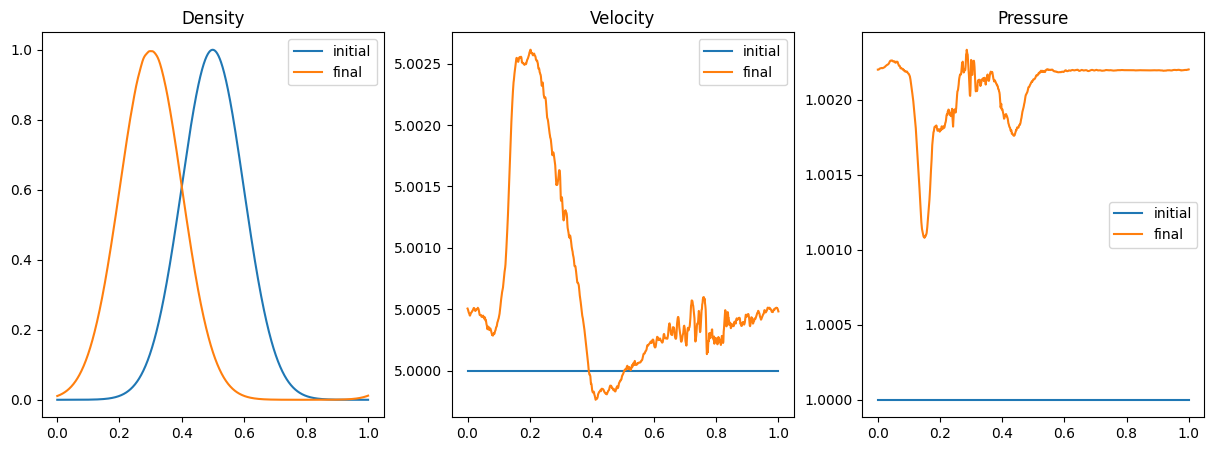

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(r, rho, label='initial')
axs[0].plot(r, rho_final, label='final')
axs[0].set_title('Density')
axs[0].legend()

axs[1].plot(r, u, label='initial')
axs[1].plot(r, u_final, label='final')
axs[1].set_title('Velocity')
axs[1].legend()

axs[2].plot(r, p, label='initial')
axs[2].plot(r, p_final, label='final')
axs[2].set_title('Pressure')
axs[2].legend()